# GNN Architectures

In [1]:
import random
import wandb
from tqdm import tqdm
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch_geometric
import torch_geometric.nn as pyg_nn
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from functools import partial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

## Load a dataset

We use the CiteSeer citation network dataset
The original paper with results on the dataset: https://arxiv.org/pdf/1603.08861.pdf

The image below shows some performance metrics from the paper. Upper sections
shows inductive methods, the lower section shows transductive methods.

![Planetoid Performance Table](planetoid-performance-table.png)

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(name='CiteSeer', root='data/CiteSeer')
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6


In [3]:
data = dataset[0]  # Get the first (and only) graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True


## Examples of GNN Architectures

In [4]:
class NodeClassifier(nn.Module):

    def __init__(self, node_dim: int, num_classes):
        super(NodeClassifier, self).__init__()
        self.logits = nn.Linear(node_dim, num_classes)

    def forward(self, x: torch.Tensor):
        return self.logits(x)

### A simple linear GNN

In [5]:
class LinearGCN(NodeClassifier):

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int, depth: int = 1):

        super(LinearGCN, self).__init__(node_dim=hidden_dim, num_classes=num_classes)

        self.layers = nn.ModuleList()
        self.layers.append(pyg_nn.GCNConv(input_dim, hidden_dim))
        for _ in range(depth - 1):
            self.layers.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        
        # Apply consecutive linear graph convolutional layers.
        for layer in self.layers:
            x = layer(x, edge_index)

        # Perform node classificaiton
        logits = super().forward(x)
        return logits

### Activation functions

In [6]:
class NonLinearGCN(LinearGCN):

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int, depth: int = 1):
        super().__init__(input_dim, hidden_dim, num_classes, depth)

        # We're using a ReLU non-linearity
        # There's a plethora of other non-linearities to choose from:
        # > https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):

        # Apply consecutive linear graph convolutional layers.
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            if i < len(self.layers) - 1:
                x = self.activation(x)

        # Perform node classificaiton
        logits = self.logits(x)
        return logits

### Using different Message Passing Operators

In [7]:
class NonLinearGNN(NodeClassifier):

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int,
                 depth: int = 1, gnn_conv: nn.Module = pyg_nn.GCNConv):
        super().__init__(hidden_dim, num_classes)

        self.layers = nn.ModuleList()
        self.layers.append(gnn_conv(input_dim, hidden_dim))
        for _ in range(depth - 1):
            self.layers.append(gnn_conv(hidden_dim, hidden_dim))

        # We're using a ReLU non-linearity
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):

        # Apply consecutive linear graph convolutional layers.
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            if i < len(self.layers) - 1:
                x = self.activation(x)

        # Perform node classificaiton
        logits = self.logits(x)
        return logits

### Let's explore some CNN techniques

In [8]:
class RegularizedGNN(NodeClassifier):

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int,
                 depth: int = 1, gnn_conv: nn.Module = pyg_nn.GCNConv,
                 dropout: float = 0.5, normalization: nn.Module = nn.LayerNorm):
        super().__init__(hidden_dim, num_classes)

        self.node_projection = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        for _ in range(depth):
            self.norms.append(normalization(hidden_dim))
            self.layers.append(gnn_conv(hidden_dim, hidden_dim))

        # We're using a ReLU non-linearity
        self.activation = nn.ReLU()

        # Regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):

        # Project the node features into the hidden space.
        x = self.node_projection(x)

        # Apply consecutive linear graph convolutional layers.
        for i, (layer, norm) in enumerate(zip(self.layers, self.norms)):
            x = norm(x)
            x = layer(x, edge_index)
            if i < len(self.layers) - 1:
                x = self.activation(x)
                x = self.dropout(x)

        # Perform node classificaiton
        logits = self.logits(x)
        return logits

In [9]:
class ResidualGNN(NodeClassifier):

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int,
                 depth: int = 1, gnn_conv: nn.Module = pyg_nn.GCNConv,
                 dropout: float = 0.5, normalization: nn.Module = nn.LayerNorm):
        super().__init__(hidden_dim, num_classes)

        self.node_projection = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        for _ in range(depth):
            # Different normalization options also available here:
            # https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#normalization-layers
            self.norms.append(normalization(hidden_dim))
            self.layers.append(gnn_conv(hidden_dim, hidden_dim))

        # We're using a ReLU non-linearity
        self.activation = nn.ReLU()

        # Regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):

        x = self.node_projection(x)

        # Apply consecutive linear graph convolutional layers.
        for i, (layer, norm) in enumerate(zip(self.layers, self.norms)):
            x_layer = norm(x)
            x_layer = layer(x_layer, edge_index)
            if i < len(self.layers) - 1:
                x_layer = self.activation(x_layer)
                x_layer = self.dropout(x_layer)

            x = x + x_layer # residual connection

        # Perform node classificaiton
        logits = self.logits(x)
        return logits

In [10]:
class SkipGNN(NodeClassifier):

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int,
                 depth: int = 1, gnn_conv: nn.Module = pyg_nn.GCNConv,
                 dropout: float = 0.5, normalization: nn.Module = nn.LayerNorm):
        super().__init__(hidden_dim * depth, num_classes)

        self.node_projection = nn.Linear(input_dim, hidden_dim)

        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        for _ in range(depth):
            self.norms.append(normalization(hidden_dim))
            self.layers.append(gnn_conv(hidden_dim, hidden_dim))

        # We're using a ReLU non-linearity
        self.activation = nn.ReLU()

        # Regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):

        x = self.node_projection(x)

        # Apply consecutive linear graph convolutional layers.
        xs = []
        for i, (layer, norm) in enumerate(zip(self.layers, self.norms)):
            x_layer = norm(x)
            x_layer = layer(x_layer, edge_index)
            if i < len(self.layers) - 1:
                x_layer = self.activation(x_layer)
                x_layer = self.dropout(x_layer)

            x = x_layer
            xs.append(x)

        x = torch.cat(xs, dim=1) # skip connections

        # Perform node classificaiton
        logits = self.logits(x)
        return logits

### Let's get a bit crazy

In [11]:
from torch_geometric.utils.dropout import dropout_edge

class ExperimentalGNN(NodeClassifier):

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int,
                 depth: int = 1, gnn_conv: nn.Module = pyg_nn.GCNConv,
                 dropout: float = 0.5, normalization: nn.Module = nn.LayerNorm,
                 edge_dropout: float = 0.0, parallel_convs: int = 1):
        super().__init__(hidden_dim, num_classes)

        self.node_projection = nn.Linear(input_dim, hidden_dim)

        self.edge_dropout = edge_dropout
        self.parallel_convs = parallel_convs

        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        for _ in range(depth):
            self.norms.append(normalization(hidden_dim))
            self.layers.append(nn.ModuleList([gnn_conv(hidden_dim, hidden_dim) for _ in range(parallel_convs)]))

        # We're using a ReLU non-linearity
        self.activation = nn.ReLU()

        # Regularization
        self.dropout = nn.Dropout(dropout)

        # Parallel attention aggregator
        self.parallel_aggregation_query = nn.Parameter(torch.Tensor(hidden_dim, 1))
        nn.init.xavier_uniform_(self.parallel_aggregation_query)

        # Depth aggregator
        # We use a sequence model to aggregate the node embeddings
        # at each depth into a single embedding
        self.depth_rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):

        # Apply edge dropout
        edge_dropout_function = partial(dropout_edge, p=self.edge_dropout,
                                        force_undirected=True, training=self.training)
        
        x = self.node_projection(x)

        # Apply consecutive linear graph convolutional layers.
        xs = []
        for i, (layer, norm) in enumerate(zip(self.layers, self.norms)):
            x_layer = norm(x)

            # Apply parallel convolutions
            x_layer_parallel = torch.stack([
                l(x_layer, edge_dropout_function(edge_index)[0]) # each set of parameters sees diff. edge dropout
                for l in layer], dim=1)
            
            # We aggregate the parallel convolutions using an attention mechanism
            dot_products = torch.matmul(x_layer_parallel, self.parallel_aggregation_query)
            attention_weights = F.softmax(dot_products, dim=1)
            x_layer = torch.sum(x_layer_parallel * attention_weights, dim=1)

            if i < len(self.layers) - 1:
                x_layer = self.activation(x_layer)
                x_layer = self.dropout(x_layer)

            x = x_layer
            xs.append(x)

        x = torch.stack(xs, dim=1) # collect depth-wise representations
        x = self.depth_rnn(x)[0][:, -1, :] # aggregate depth-wise representations

        # Perform node classificaiton
        logits = self.logits(x)
        return logits

## Train a GNN using PyTorch Geometric Layers

We use PyTorch Lightning to simplify the training code: https://lightning.ai/docs/pytorch/stable/

In [12]:
class GNNWrapper(pl.LightningModule):
    """
    A Pytorch Lightning Wrapper to train
    sequence models (classifiers/regressors)
    """

    def __init__(
        self,
        dataset,
        model,
    ) -> None:
        
        super().__init__()

        # Store the dataset and define
        # some hyperparameters of the model, these could
        # be passed by arguments also.
        self.dataset = dataset
        self.data = dataset[0]
        self.learning_rate = 1e-4
        self.weight_decay = 1e-5

        # Define the model architecture
        # Here we use a simple GCN model
        # Pytorch Geometric provides many other: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html
        # We will learn more about them in the upcoming lectures
        self.model = model

        # We use Cross Entropy Loss as a task specific loss
        self.loss = nn.CrossEntropyLoss()

        # Utility variables to track the training and validation loss/accuracy
        self.train_loss = []
        self.val_loss = []

        self.train_proba = []
        self.train_labels = []
        self.val_proba = []
        self.val_labels = []
        self.val_hidden = []
        self.val_hidden_plot_patience = 0

        self.save_hyperparameters(ignore=["model", "dataset"])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        We define the forward pass of the model.
        """
        logits = self.model(x, self.data.edge_index)
        return logits

    def compute_loss(self, logits: torch.Tensor, labels: torch.Tensor, validate: bool = False) -> torch.Tensor:
        """
        Loss computation, signal from the training nodes
        again for simplicity we consider all other nodes as validation nodes
        """
        mask = self.data.train_mask
        if validate:
            mask = torch.logical_not(mask)

        # Task specific loss
        train_logits = logits[mask]
        train_labels = labels[mask]

        loss = self.loss(train_logits, train_labels)

        return loss

    def training_step(self, batch, batch_idx: int):
        """
        Define a single learning step
        """

        logits = self(data.x)
        loss = self.compute_loss(logits, data.y)

        train_proba = F.softmax(logits[self.data.train_mask], dim=-1).detach().cpu().numpy()
        train_labels = data.y[self.data.train_mask].detach().cpu().numpy()

        self.train_loss.append(loss.detach().cpu().numpy())
        self.train_proba.append(train_proba)
        self.train_labels.append(train_labels)

        return loss

    def on_train_epoch_end(self) -> None:
        """
        At the end of an epoch we compute and log metrics
        """
        train_loss = np.mean(self.train_loss)
        self.log("train/loss", train_loss, prog_bar=True)

        train_proba = np.concatenate(self.train_proba)
        train_labels = np.concatenate(self.train_labels)
        train_acc = accuracy_score(train_labels, np.argmax(train_proba, axis=-1))
        self.log("train/accuracy", train_acc, prog_bar=False)

        self.train_loss.clear()
        self.train_proba.clear()
        self.train_labels.clear()

    def validation_step(self, batch, batch_idx: int):
        """
        Define a validation step, here very similar to the training step
        For simplicity we consider all nodes not in the training set as validation nodes
        """

        logits = self(data.x)
        loss = self.compute_loss(logits, data.y, validate=True)

        val_mask = torch.logical_not(self.data.train_mask)
        val_proba = F.softmax(logits[val_mask], dim=-1).detach().cpu().numpy()
        val_labels = data.y[val_mask].detach().cpu().numpy()

        self.val_loss.append(loss.detach().cpu().numpy())
        self.val_proba.append(val_proba)
        self.val_labels.append(val_labels)

    def on_validation_epoch_end(self) -> None:
        """
        Compute and log validation metrics, and visualize the hidden layers
        """
        val_loss = float(np.mean(self.val_loss))
        self.log("val/loss", val_loss, prog_bar=True)

        val_proba = np.concatenate(self.val_proba)
        val_labels = np.concatenate(self.val_labels)
        val_acc = accuracy_score(val_labels, np.argmax(val_proba, axis=-1))
        self.log("val/accuracy", val_acc, prog_bar=False)

        self.val_loss.clear()
        self.val_proba.clear()
        self.val_labels.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
        )
        return optimizer


### Run experiments

In [13]:
# Select a model
GNN_DEPTH = 4
GNN_HIDDEN = 48

model_dictionary = {
    'linear-gcn': LinearGCN(
        input_dim=dataset.num_features, hidden_dim=GNN_HIDDEN,
        num_classes=dataset.num_classes, depth=GNN_DEPTH),
    'nonlinear-gcn': NonLinearGCN(
        input_dim=dataset.num_features, hidden_dim=GNN_HIDDEN,
        num_classes=dataset.num_classes, depth=GNN_DEPTH),
    'nonlinear-gat': NonLinearGNN(
        input_dim=dataset.num_features, hidden_dim=GNN_HIDDEN,
        num_classes=dataset.num_classes, depth=GNN_DEPTH, gnn_conv=pyg_nn.GATConv),
    'regularized-gcn': RegularizedGNN(
        input_dim=dataset.num_features, hidden_dim=GNN_HIDDEN,
        num_classes=dataset.num_classes, depth=GNN_DEPTH,
        dropout=0.1, normalization=nn.LayerNorm),
    'residual-gcn': ResidualGNN(
        input_dim=dataset.num_features, hidden_dim=GNN_HIDDEN,
        num_classes=dataset.num_classes, depth=GNN_DEPTH,
        dropout=0.0, normalization=nn.Identity),
    'skip-gcn': SkipGNN(
        input_dim=dataset.num_features, hidden_dim=GNN_HIDDEN,
        num_classes=dataset.num_classes, depth=GNN_DEPTH,
        dropout=0.0, normalization=nn.Identity),
    'experimental-gnn': ExperimentalGNN(
        input_dim=dataset.num_features, hidden_dim=GNN_HIDDEN,
        num_classes=dataset.num_classes, depth=GNN_DEPTH,
        dropout=0.0, normalization=nn.Identity,
        edge_dropout=0.05, parallel_convs=2),
}

In [14]:
# for name, model in model_dictionary.items():

#     # We instantiate a training wrapper for our model
#     model_wrapper = GNNWrapper(dataset, model)

#     # We will log the training to WandB: https://wandb.ai/
#     # logger = TensorBoardLogger(save_dir="logs", name=name)
#     logger = WandbLogger(name=name, project="adlg-gnn")

#     # We perform early stopping to prevent overfitting
#     early_stopping = EarlyStopping(monitor=f"val/loss", mode="min", patience=3)

#     # We instantiate a Pytorch Lightning trainer
#     trainer = pl.Trainer(
#         accelerator="cpu",
#         max_epochs=2000,
#         logger=logger,
#         callbacks=[early_stopping],
#         check_val_every_n_epoch=10,
#     )

#     # We use dummy dataloaders, as we passed the single graph to the model wrapper
#     train_loader = DataLoader(TensorDataset(torch.arange(1)), batch_size=1, shuffle=False)
#     val_loader = DataLoader(TensorDataset(torch.arange(1)), batch_size=1, shuffle=False)

#     # We train the model
#     trainer.fit(model_wrapper, train_loader, val_loader)

#     trainer.validate(model_wrapper, val_loader)

#     wandb.finish()

2.1 Data Exploration

In [15]:
import networkx as nx
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

dataset = Planetoid(name='Cora', root='data/cora')
print(f'Dataset: {dataset}')
data = dataset[0]
print(f'Data: {data} \n')

print("1. How many nodes and edges does the graph have?")
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {int(data.num_edges/2)} \n')

print("2. How many features does each node have?")
print(f'Number of features: {dataset.num_features} \n')

print("3. What is the longest shortest path in the graph (diameter)?")
G = to_networkx(data, to_undirected=True)
connected_components = list(nx.connected_components(G))
diameters = []
for i, component in enumerate(connected_components):
    subgraph = G.subgraph(component)
    diameters.append(nx.diameter(subgraph))
print(f"Diameter: {max(diameters)} \n")

print("4. What other graph statistics could be insightful when developing a model?")
print(f'Number of classes: {dataset.num_classes}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora()
Data: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708]) 

1. How many nodes and edges does the graph have?
Number of nodes: 2708
Number of edges: 5278 

2. How many features does each node have?
Number of features: 1433 

3. What is the longest shortest path in the graph (diameter)?


Diameter: 19 

4. What other graph statistics could be insightful when developing a model?
Number of classes: 7
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


2.2 Label Propagation with full observations

In [16]:
from collections import Counter

num_runs = 3
majority = np.empty((num_runs, data.num_nodes))

nodes = np.arange(data.num_nodes)
for node in nodes:
    indices = torch.argwhere(data.edge_index[1] == node).flatten().detach().numpy()
    neighbors = data.edge_index[0][indices].detach().numpy()
    neighbor_labels = data.y[neighbors].detach().numpy()
    label_counts = Counter(neighbor_labels) # A dict storing the number of occurrences of each label
    largest_count = max(label_counts.values()) # The largest number of occurrences
    frequentist_labels = [key for key, value in label_counts.items() if value == largest_count]
    for i in range(num_runs):
        np.random.seed(i)
        majority[i][node] = np.random.choice(frequentist_labels)

# Calculate accuracies over several runs
accuracies = []
for i in range(num_runs):
    accuracies.append(accuracy_score(data.y.numpy(), majority[i]))
print("Accuracy mean:", np.mean(accuracies))
print("Accuracy std:", np.std(accuracies))

Accuracy mean: 0.8643525356967011
Accuracy std: 0.0013926278309927007


2.3 Baseline without Graph Structure

In [17]:
def calculate_trained_mlp_accuracy(model, x, y, mask):
    model.eval()
    correct = 0
    total = 0
    pred = model(x[mask]).max(dim=1)[1]
    correct += pred.eq(y[mask]).sum().item()
    total += torch.sum(mask).item()
    return correct / total

def use_trained_mlp(run):
    # model and optimizer
    baseline_mlp = NodeClassifier(dataset.num_features, dataset.num_classes)
    optimizer = torch.optim.Adam(baseline_mlp.parameters(), lr=0.01)

    # train
    for epoch in range(100):
        baseline_mlp.train()
        feature, label = data.x[data.train_mask], data.y[data.train_mask]
        pred = baseline_mlp(feature)
        loss = F.cross_entropy(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 20 == 0:
            accuracy = calculate_trained_mlp_accuracy(baseline_mlp, data.x, data.y, data.val_mask)
            print("Run: {}\tEpoch: {}\tValidation accuracy: {}".format(run + 1, epoch + 1, accuracy))

    # test
    accuracy = calculate_trained_mlp_accuracy(baseline_mlp, data.x, data.y, data.test_mask)
    accuracies.append(accuracy)

num_runs = 3
accuracies = []
for run in range(num_runs):
    use_trained_mlp(run)
print("Model: MLP")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

Run: 1	Epoch: 20	Validation accuracy: 0.482
Run: 1	Epoch: 40	Validation accuracy: 0.478
Run: 1	Epoch: 60	Validation accuracy: 0.454
Run: 1	Epoch: 80	Validation accuracy: 0.454
Run: 1	Epoch: 100	Validation accuracy: 0.45
Run: 2	Epoch: 20	Validation accuracy: 0.486
Run: 2	Epoch: 40	Validation accuracy: 0.48
Run: 2	Epoch: 60	Validation accuracy: 0.46
Run: 2	Epoch: 80	Validation accuracy: 0.452
Run: 2	Epoch: 100	Validation accuracy: 0.448
Run: 3	Epoch: 20	Validation accuracy: 0.474
Run: 3	Epoch: 40	Validation accuracy: 0.472
Run: 3	Epoch: 60	Validation accuracy: 0.46
Run: 3	Epoch: 80	Validation accuracy: 0.446
Run: 3	Epoch: 100	Validation accuracy: 0.446
Model: MLP
Accuracies: [0.44, 0.449, 0.451]
Mean: 0.4466666666666667
Standard deviation: 0.004784233364802446


In [18]:
### Other classification models
model_list = [LogisticRegression(), 
              RandomForestClassifier(), 
              GradientBoostingClassifier(),
              SVC()]

x_train, x_val, x_test = data.x[data.train_mask], data.x[data.val_mask], data.x[data.test_mask]
y_train, y_val, y_test = data.y[data.train_mask], data.y[data.val_mask], data.y[data.test_mask]

def use_other_classification_models(model):
    print("Model: {}".format(model))
    for run in range(num_runs):
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracies[i][run] = accuracy_score(y_pred, y_test)
        y_val_pred = model.predict(x_val)
        print("Run: {}\tValidation accuracy: {}".format(run + 1, accuracy_score(y_val_pred, y_val)))
        
    print("Accuracies: {}".format(accuracies[i]))
    print("Mean: {}".format(np.mean(accuracies[i])))
    print("Standard deviation: {}".format(np.std(accuracies[i])))
    print("=========================================")

num_runs = 3
accuracies = np.empty((len(model_list), num_runs))
for i, model in enumerate(model_list):
    use_other_classification_models(model)

Model: LogisticRegression()
Run: 1	Validation accuracy: 0.522
Run: 2	Validation accuracy: 0.522
Run: 3	Validation accuracy: 0.522
Accuracies: [0.575 0.575 0.575]
Mean: 0.575
Standard deviation: 0.0
Model: RandomForestClassifier()
Run: 1	Validation accuracy: 0.53
Run: 2	Validation accuracy: 0.538
Run: 3	Validation accuracy: 0.526
Accuracies: [0.566 0.593 0.556]
Mean: 0.5716666666666667
Standard deviation: 0.015627610892974698
Model: GradientBoostingClassifier()
Run: 1	Validation accuracy: 0.496
Run: 2	Validation accuracy: 0.498
Run: 3	Validation accuracy: 0.484
Accuracies: [0.537 0.539 0.52 ]
Mean: 0.532
Standard deviation: 0.008524474568362955
Model: SVC()
Run: 1	Validation accuracy: 0.546
Run: 2	Validation accuracy: 0.546
Run: 3	Validation accuracy: 0.546
Accuracies: [0.56 0.56 0.56]
Mean: 0.56
Standard deviation: 0.0


2.4 Untrained GNNs

In [19]:
class GNN_Baseline(nn.Module):

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int,
                 depth: int = 1, gnn_conv: nn.Module = pyg_nn.GCNConv):
        
        super(GNN_Baseline, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(gnn_conv(input_dim, hidden_dim))
        for _ in range(depth - 1):
            self.layers.append(gnn_conv(hidden_dim, hidden_dim))
        self.activation = nn.ReLU()
        self.logits = nn.Linear(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):

        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            if i < len(self.layers) - 1:
                x = self.activation(x)
        emb = x
        logits = self.logits(emb)
        logits = F.softmax(logits, dim=1)
        return emb, logits
    
class MLP_Baseline(nn.Module):
    def __init__(self, node_dim: int, hidden_dim: int, depth: int = 1):
        super(MLP_Baseline, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(node_dim, hidden_dim))
        for _ in range(depth - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))

    def forward(self, x: torch.Tensor):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x

In [20]:
def plot_embeddings(node_embeddings, labels,):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    tsne = TSNE(n_components=2)
    h_projected = tsne.fit_transform(node_embeddings)
    plt.scatter(h_projected[:, 0], h_projected[:, 1], s=15, c=labels, cmap="Set2")
    plt.savefig("")

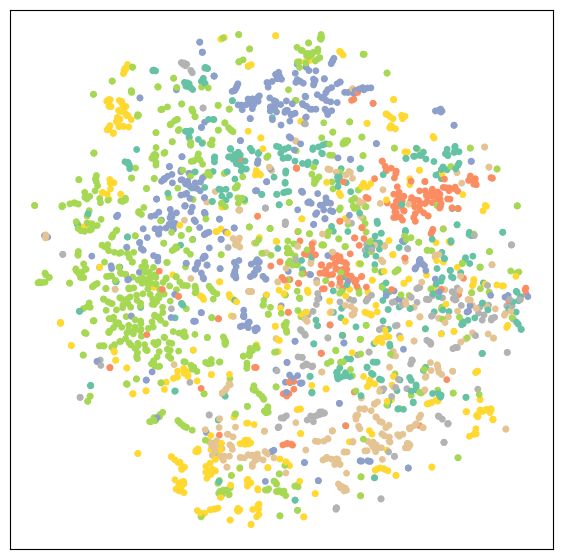

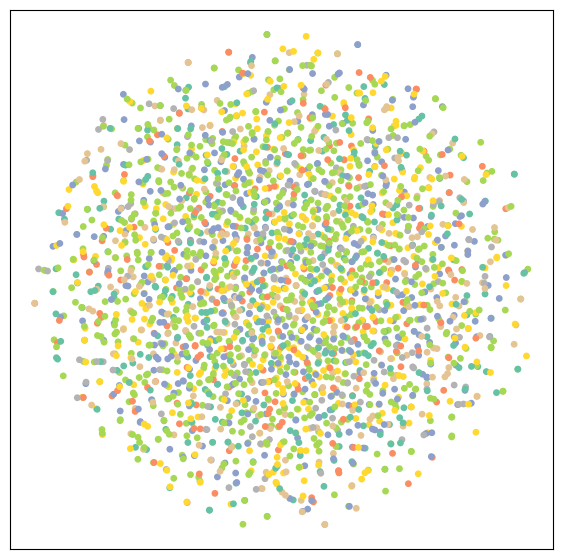

In [21]:
model_untrain = GNN_Baseline(dataset.num_features, 32, dataset.num_classes, 3)
emb, _ = model_untrain(data.x, data.edge_index)
rv = torch.rand_like(emb)

plot_embeddings(emb.detach().numpy(), data.y)
plot_embeddings(rv.detach().numpy(), data.y)

In [22]:
def compute_classification_accuracy(emb, data):
    lr = LogisticRegression()
    lr.fit(emb[data.train_mask].detach().numpy(), data.y[data.train_mask])
    pred = lr.predict(emb[data.test_mask].detach().numpy())
    return accuracy_score(pred, data.y[data.test_mask])

num_runs = 3
accuracies = np.empty((3, num_runs))

# 1. Use GNN with node features to create embeddings
for run in range(num_runs):
    model_1 = GNN_Baseline(dataset.num_features, 32, dataset.num_classes, 3)
    emb_1, _ = model_1(data.x, data.edge_index)
    accuracies[0][run] = compute_classification_accuracy(emb_1, data)
print("Untrained GNN with node features: ")
print("Accuracies: {}".format(accuracies[0]))
print("Mean: {}".format(np.mean(accuracies[0])))
print("Standard deviation: {}".format(np.std(accuracies[0])))
print("=========================================")

# 2. Use MLP with node features to create embeddings
for run in range(num_runs):
    model_2 = MLP_Baseline(dataset.num_features, 32, 3)
    emb_2 = model_2(data.x)
    accuracies[1][run] = compute_classification_accuracy(emb_2, data)
print("Untrained MLP with node features: ")
print("Accuracies: {}".format(accuracies[1]))
print("Mean: {}".format(np.mean(accuracies[1])))
print("Standard deviation: {}".format(np.std(accuracies[1])))
print("=========================================")

# 3. Use random embeddings
for run in range(num_runs):
    emb_3 = torch.rand_like(emb_1)
    accuracies[2][run] = compute_classification_accuracy(emb_3, data)
print("Random embeddings: ")
print("Accuracies: {}".format(accuracies[2]))
print("Mean: {}".format(np.mean(accuracies[2])))
print("Standard deviation: {}".format(np.std(accuracies[2])))
print("=========================================")

Untrained GNN with node features: 
Accuracies: [0.318 0.366 0.358]
Mean: 0.34733333333333327
Standard deviation: 0.020997354330698156
Untrained MLP with node features: 
Accuracies: [0.167 0.233 0.194]
Mean: 0.19800000000000004
Standard deviation: 0.027092434368288135
Random embeddings: 
Accuracies: [0.136 0.142 0.129]
Mean: 0.13566666666666669
Standard deviation: 0.005312459150169736


2.5 Trained GNNs

In [23]:
class GNN_Refined(nn.Module):

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int,
                 num_gnn_layers: int = 1, gnn_conv: nn.Module = pyg_nn.GCNConv):
        
        super(GNN_Refined, self).__init__()
        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(gnn_conv(input_dim, hidden_dim))
        for _ in range(num_gnn_layers - 1):
            self.gnn_layers.append(gnn_conv(hidden_dim, hidden_dim))
        self.activation = nn.ReLU()
        self.logits = nn.Linear(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        for i, layer in enumerate(self.gnn_layers):
            x = layer(x, edge_index)
            if i < len(self.gnn_layers) - 1:
                x = self.activation(x)
                
        logits = self.logits(x)
        logits = F.log_softmax(logits, dim=1)
        return logits

In [24]:
def calculate_trained_gnn_accuracy(model, x, y, mask, edge_index):
    model.eval()
    correct = 0
    total = 0
    pred = model(x, edge_index).max(dim=1)[1]
    correct += (pred[mask]).eq(y[mask]).sum().item()
    total += torch.sum(mask).item()
    return correct / total

def use_trained_gnn(run, seed):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_train = GNN_Refined(input_dim=dataset.num_features, 
                            hidden_dim=32, 
                            num_classes=dataset.num_classes, 
                            num_gnn_layers=2)
    optimizer = torch.optim.Adam(gnn_train.parameters(), lr=0.01, weight_decay=5e-4)

    # train
    for epoch in range(100):
        gnn_train.train()
        feature, edge_index, label = data.x, data.edge_index, data.y
        pred = gnn_train(feature, edge_index)
        loss = F.nll_loss(pred[data.train_mask], label[data.train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 20 == 0:
            accuracy = calculate_trained_gnn_accuracy(gnn_train, data.x, data.y, data.val_mask, data.edge_index)
            print("Run: {}\tEpoch: {}\tValidation accuracy: {}".format(run + 1, epoch + 1, accuracy))

    # test
    accuracy = calculate_trained_gnn_accuracy(gnn_train, data.x, data.y, data.test_mask, data.edge_index)
    accuracies.append(accuracy)

num_runs = 3
seeds = [0, 11, 19260817]
accuracies = []
for run in range(num_runs):
    use_trained_gnn(run, seeds[run])
print("Model: Trained GNN")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

Run: 1	Epoch: 20	Validation accuracy: 0.764
Run: 1	Epoch: 40	Validation accuracy: 0.744
Run: 1	Epoch: 60	Validation accuracy: 0.76
Run: 1	Epoch: 80	Validation accuracy: 0.762
Run: 1	Epoch: 100	Validation accuracy: 0.76
Run: 2	Epoch: 20	Validation accuracy: 0.77
Run: 2	Epoch: 40	Validation accuracy: 0.782
Run: 2	Epoch: 60	Validation accuracy: 0.78
Run: 2	Epoch: 80	Validation accuracy: 0.782
Run: 2	Epoch: 100	Validation accuracy: 0.772
Run: 3	Epoch: 20	Validation accuracy: 0.762
Run: 3	Epoch: 40	Validation accuracy: 0.754
Run: 3	Epoch: 60	Validation accuracy: 0.764
Run: 3	Epoch: 80	Validation accuracy: 0.77
Run: 3	Epoch: 100	Validation accuracy: 0.782
Model: Trained GNN
Accuracies: [0.801, 0.81, 0.804]
Mean: 0.805
Standard deviation: 0.003741657386773945


2.6 Visualizing Graph Attention Networks

In [25]:
class GNN_Attention(nn.Module):

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int,
                 num_gnn_layers: int = 1, num_heads: int = 4, gnn_att: nn.Module = pyg_nn.GATConv):
        
        super(GNN_Attention, self).__init__()
        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(gnn_att(input_dim, hidden_dim, heads=num_heads))
        for _ in range(num_gnn_layers - 1):
            self.gnn_layers.append(gnn_att(hidden_dim*num_heads, hidden_dim, heads=num_heads))
        self.activation = nn.ReLU()
        self.logits = nn.Linear(hidden_dim*num_heads, num_classes)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, return_attention_weights=False):
        if return_attention_weights:
            for i, layer in enumerate(self.gnn_layers):
                x, att_wei = layer(x, edge_index, return_attention_weights=True)
                if i < len(self.gnn_layers) - 1:
                    x = self.activation(x)
        else:
            for i, layer in enumerate(self.gnn_layers):
                x = layer(x, edge_index)
                if i < len(self.gnn_layers) - 1:
                    x = self.activation(x)
                
        logits = self.logits(x)
        logits = F.log_softmax(logits, dim=1)   
        
        if return_attention_weights:
            return logits, att_wei
        else:
            return logits

In [26]:
def calculate_trained_gnn_accuracy(model, x, y, mask, edge_index):
    model.eval()
    correct = 0
    total = 0
    pred = model(x, edge_index).max(dim=1)[1]
    correct += (pred[mask]).eq(y[mask]).sum().item()
    total += torch.sum(mask).item()
    return correct / total

def use_attention_gnn(run, seed):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_train = GNN_Attention(input_dim=dataset.num_features, 
                              hidden_dim=32, 
                              num_classes=dataset.num_classes, 
                              num_gnn_layers=2, 
                              num_heads=4)
    optimizer = torch.optim.Adam(gnn_train.parameters(), lr=0.01, weight_decay=5e-4)

    # train
    for epoch in range(200):
        gnn_train.train()
        feature, edge_index, label = data.x, data.edge_index, data.y
        pred = gnn_train(feature, edge_index)
        loss = F.nll_loss(pred[data.train_mask], label[data.train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 20 == 0:
            accuracy = calculate_trained_gnn_accuracy(gnn_train, data.x, data.y, data.val_mask, data.edge_index)
            print("Run: {}\tEpoch: {}\tValidation accuracy: {}".format(run + 1, epoch + 1, accuracy))

    # test
    accuracy = calculate_trained_gnn_accuracy(gnn_train, data.x, data.y, data.test_mask, data.edge_index)
    accuracies.append(accuracy)

    # output the trained model for the next question
    return gnn_train

num_runs = 3
seeds = [42, 418004, 19260817]
accuracies = []
for run in range(num_runs):
    attention_gnn = use_attention_gnn(run, seeds[run])
print("Model: Trained Attention GNN")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

Run: 1	Epoch: 20	Validation accuracy: 0.696
Run: 1	Epoch: 40	Validation accuracy: 0.722
Run: 1	Epoch: 60	Validation accuracy: 0.756
Run: 1	Epoch: 80	Validation accuracy: 0.764
Run: 1	Epoch: 100	Validation accuracy: 0.764
Run: 1	Epoch: 120	Validation accuracy: 0.77
Run: 1	Epoch: 140	Validation accuracy: 0.77
Run: 1	Epoch: 160	Validation accuracy: 0.766
Run: 1	Epoch: 180	Validation accuracy: 0.764
Run: 1	Epoch: 200	Validation accuracy: 0.764
Run: 2	Epoch: 20	Validation accuracy: 0.716
Run: 2	Epoch: 40	Validation accuracy: 0.73
Run: 2	Epoch: 60	Validation accuracy: 0.762
Run: 2	Epoch: 80	Validation accuracy: 0.76
Run: 2	Epoch: 100	Validation accuracy: 0.766
Run: 2	Epoch: 120	Validation accuracy: 0.762
Run: 2	Epoch: 140	Validation accuracy: 0.758
Run: 2	Epoch: 160	Validation accuracy: 0.746
Run: 2	Epoch: 180	Validation accuracy: 0.738
Run: 2	Epoch: 200	Validation accuracy: 0.734
Run: 3	Epoch: 20	Validation accuracy: 0.706
Run: 3	Epoch: 40	Validation accuracy: 0.738
Run: 3	Epoch: 60	Validat

In [27]:
np.random.seed(42)
test_indices = torch.argwhere(data.test_mask).flatten().detach().numpy()
nodes = np.random.choice(test_indices, size=(5,))

feature, edge_index, label = data.x, data.edge_index, data.y
pred, att_weight = attention_gnn(feature, edge_index, return_attention_weights=True)

# 13264 = 10556(edges) + 2708(nodes)
edge_index_with_self = att_weight[0] # shape: [2, 13264]
weights = att_weight[1] # shape: [13264, num_heads]

for node in nodes:
    node_label = data.y[node].item()
    locations = torch.argwhere(edge_index_with_self[1] == node).flatten().detach().numpy()
    neighbors = edge_index_with_self[0][locations].detach().numpy()
    neighbor_weights = weights[locations].detach().numpy()
    neighbor_labels = data.y[neighbors].detach().numpy()
    print("[Node: {}, Node label: {}]".format(node, node_label))
    print("Neighbors\t Neighbor weights\t\t\t\t\t Neighbor labels")
    for neighbor, neighbor_weight, neighbor_label in zip(neighbors, neighbor_weights, neighbor_labels):
        print(neighbor, "\t\t", neighbor_weight, "\t\t", neighbor_label)
    print()


[Node: 1810, Node label: 3]
Neighbors	 Neighbor weights					 Neighbor labels
13 		 [0.02092899 0.02017374 0.02006453 0.02160361] 		 3
27 		 [0.0212658  0.02044397 0.02050124 0.02186861] 		 3
224 		 [0.02050301 0.02014782 0.01982782 0.02153578] 		 4
230 		 [0.0208402  0.02031596 0.02081969 0.02153932] 		 3
351 		 [0.02144982 0.020628   0.02083938 0.02199924] 		 3
481 		 [0.02101243 0.02014706 0.02140746 0.02149873] 		 2
482 		 [0.02186687 0.02073179 0.0208747  0.02188052] 		 3
511 		 [0.02058244 0.02001211 0.02032086 0.02154051] 		 3
549 		 [0.02047633 0.02004242 0.02029451 0.02144978] 		 3
568 		 [0.02063292 0.02004011 0.0202968  0.02154635] 		 3
576 		 [0.01931587 0.01913928 0.01766909 0.02066719] 		 3
716 		 [0.02280981 0.02174482 0.02202906 0.02226957] 		 3
719 		 [0.04537266 0.05879904 0.06564134 0.03238241] 		 1
790 		 [0.02136041 0.02042138 0.02103815 0.02171734] 		 3
795 		 [0.02149358 0.02040693 0.0217359  0.02192252] 		 3
835 		 [0.019646   0.01927296 0.02039923 0.02103361] 		